# Class 3: Introduction to Networkx 2 — Graph Properties & Algorithms

Goal of today's class:
1. Continue exploring `networkx`
2. Build a base of useful functions for network analysis
__________

1. Come in. Sit down. Open Teams.
2. Make sure your notebook from last class is saved.
3. Run `python3 git_fixer2.py`
4. Github:
    - git add ... (add the file that you changed, aka the `_MODIFIED` one)
    - git commit -m "your changes"
    - git push origin main
________a

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')
rc('axes', axisbelow=True)

#### Recall, from our last class:
**Source:** [Adamic, L. A., & Glance, N. (2005)](https://doi.org/10.1145/1134271.1134277https://doi.org/10.1145/1134271.1134277). The political blogosphere and the 2004 US election: Divided they blog. In *Proceedings of the 3rd International Workshop on Link Discovery* (pp. 36-43).

In the following we will learn how to load a directed graph, extract a vertex-induced subgraph, and compute the in- and out-degree of the vertices of the graph. We will use a directed graph that includes a collection of hyperlinks between weblogs on US politics, recorded in 2005 by Adamic and Glance.

The data are included in two tab-separated files:
* `polblogs_nodes.tsv`: node id, node label, political orientation (0 = left or liberal, 1 = right or conservative).
* `polblogs_edges.tsv`: source node id, target node id. 

#### Step-by-step way to make this network:
1. One-by-one add nodes (blogs)
2. Connect nodes based on hyperlinks between blogs

In [10]:
digraph = nx.DiGraph()
with open('data/polblogs_nodes_class.tsv','r') as fp:
    for line in fp:
        node_id, node_label, node_political = line.strip().split('\t')
        political_orientation = 'liberal' if node_political == '0' else 'conservative'
        digraph.add_node(node_id, website=node_label, political_orientation=political_orientation)
        
with open('data/polblogs_edges_class.tsv','r') as fp:
    for line in fp:
        source_node_id, target_node_id = line.strip().split('\t')
        digraph.add_edge(source_node_id, target_node_id)
        
degree = digraph.degree()
in_degree = digraph.in_degree()
out_degree = digraph.out_degree()

# I ususally make this a dictionary straight away
degree = dict(degree)
#print(degree)
in_degree = dict(in_degree)
out_degree = dict(out_degree)

deg_vals = list(degree.values())
in_deg_vals = list(in_degree.values())
out_deg_vals = list(out_degree.values())

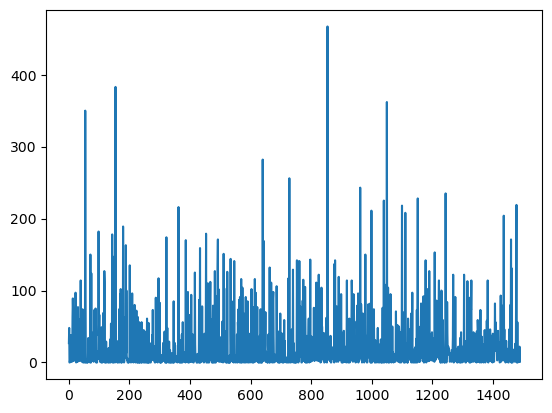

In [4]:
plt.plot(deg_vals)

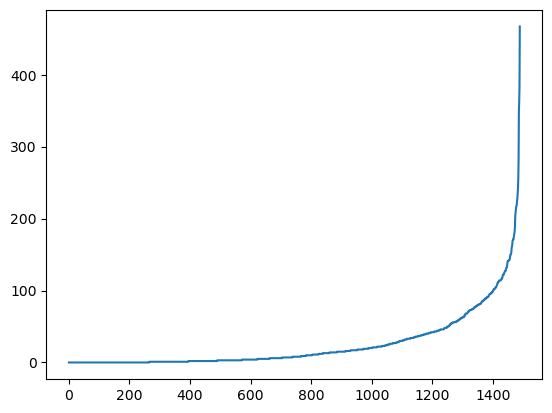

In [5]:
plt.plot(sorted(deg_vals))

In [6]:
from collections import Counter

In [7]:
min_deg = 0
max_deg = max(deg_vals)
deg_bins = {i:0 for i in range(min_deg, max_deg+1)}
for i,j in dict(Counter(deg_vals)).items():
    deg_bins[i] += j

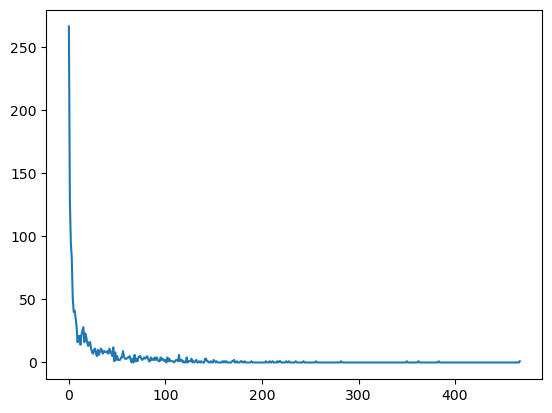

In [8]:
plt.plot(list(deg_bins.keys()),list(deg_bins.values()))

**Question**: Is this the most informative way to visualize this distribution?

##### Starting the class out with a challenge

In [20]:
def degree_distribution(G, number_of_bins=15, log_binning=True, density=True):
    """
    Given a degree sequence, return the y values (probability) and the
    x values (support) of a degree distribution that you're going to plot.
    
    Parameters
    ----------
    G (nx.Graph):
        the network whose degree distribution to calculate

    number_of_bins (int):
        length of output vectors
    
    log_binning (bool):
        if you are plotting on a log-log axis, then this is useful
    
    density (bool):
        whether to return counts or probability density (default: True)
        Note: probability densities integrate to 1 but do not sum to 1. 

    Returns
    -------
    hist, bins (np.ndarray):
        probability density if density=True node counts if density=False; binned edges
    
    """
    
    # Step 1: We will first need to define the support of our distribution

    degree = dict(G.degree())
    deg_vals = list(degree.values())
    max_deg = max(deg_vals)
    
    
    
    # Step 2: Then we'll need to construct bins
    
    if log_binning:
        bins = np.logspace(0, np.log10(max_deg+1), num=number_of_bins+1)
    else:
        bins = np.linspace(0, max_deg+1, num=number_of_bins+1)
    
    # Step 3: Then we can compute the histogram using numpy
    hist, _ = np.histogram(deg_vals, bins, density=density)
    
    return bins[1:], hist

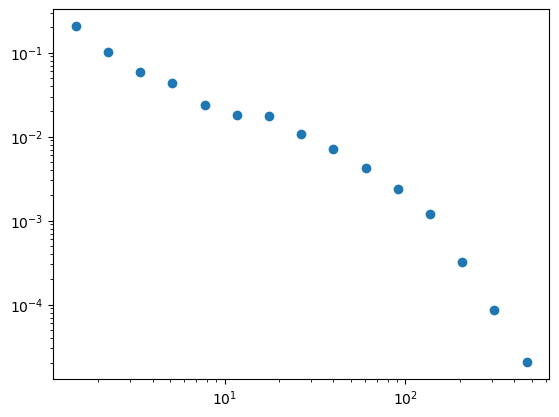

In [21]:
G = digraph.copy()
bins, probs = degree_distribution(G, number_of_bins=15, log_binning=True, density=True)
plt.loglog(bins, probs, marker='o', lw=0)


____________

## Degree Distribution

The **degree distribution** $P(k)$ of *undirected* graphs is defined as the probability that any randomly chosen vertex has degree $k$.

In *directed* graphs, we need to consider two distributions: the **in-degree** $P(k_{in})$ and **out-degree** $P(k_{out})$ distributions, defined as the probability that a randomly chosen vertex has *in-degree* $k_{in}$ and *out-degree* $k_{out}$, respectively. 

In many real world networks, degree distributions are *skewed* and *highly variable* (i.e. the support of the distribution spans several orders of magnitude). In many cases, this **heavy tailed** behavior can be approximated by a power-law decay $P(k)\sim k^{-\alpha}$.

![https://networksciencebook.com/images/ch-04/figure-4-6.jpg](https://networksciencebook.com/images/ch-04/figure-4-6.jpg)
Source: http://barabasi.com/networksciencebook/chapter/4#hubs

;) don't look below
_______________

In [22]:
def degree_distribution(G, number_of_bins=15, log_binning=True, density=True):
    """
    Given a degree sequence, return the y values (probability) and the
    x values (support) of a degree distribution that you're going to plot.
    
    Parameters
    ----------
    G (nx.Graph):
        the network whose degree distribution to calculate

    number_of_bins (int):
        length of output vectors
    
    log_binning (bool):
        if you are plotting on a log-log axis, then this is useful
    
    density (bool):
        whether to return counts or probability density (default: True)
        Note: probability densities integrate to 1 but do not sum to 1. 
        
    Returns
    -------
    hist, bins (np.ndarray):
        probability density if density=True node counts if density=False; binned edges
    
    """
    
    # Step 1: We will first need to define the support of our distribution
    k = list(dict(G.degree()).values()) # get the degree of each node
    kmax = np.max(k)                    # get the maximum degree
    
    
    # Step 2: Then we'll need to construct bins
    if log_binning:
        # array of bin edges including rightmost and leftmost
        bins = np.logspace(0,np.log10(kmax+1),number_of_bins+1)
    
    else:
        bins = np.linspace(0,kmax+1,num=number_of_bins+1)
    
    # Step 3: Then we can compute the histogram using numpy
    hist, _ = np.histogram(k,bins,density=density)

    
    
    return bins[1:], hist

15 15


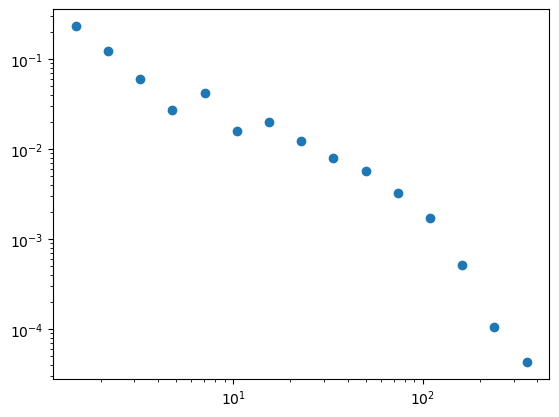

In [23]:
G0 = nx.to_undirected(digraph)
x, y = degree_distribution(G0)
print(len(x),len(y))

plt.loglog(x, y,marker='o',lw=0);

In [24]:
x1,y1 = plot_degree(list(in_degree.values()), number_of_bins=80, log_binning=True, base=2)
x2,y2 = plot_degree(list(out_degree.values()), number_of_bins=80, log_binning=True, base=2)

fig, ax = plt.subplots(1,1,figsize=(4.5,4),dpi=125)

ax.loglog(x1, y1,'o', color=cols[4], label='in-degree', alpha=0.8, mec='.1')
ax.loglog(x2, y2,'s', color=cols[6], label='out-degree', alpha=0.8, mec='.4')
ax.set_xlabel(r"$k$",fontsize='large')
ax.set_ylabel(r"$P(k)$",fontsize='large')
ax.legend(fontsize='small')

ax.grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')

plt.savefig('figs/pngs/PolBlogs_inout_degreedist.png', dpi=425, bbox_inches='tight')
plt.savefig('figs/pdfs/PolBlogs_inout_degreedist.pdf', bbox_inches='tight')
plt.show()

NameError: name 'plot_degree' is not defined

In [ ]:
# Note: your plots will look stupid if you don't do log binning...
nbins = 50
fig, ax = plt.subplots(1,2,figsize=(10,4),dpi=150)
plt.subplots_adjust(wspace=0.3)

x1,y1 = plot_degree(list(in_degree.values()), number_of_bins=nbins, log_binning=True, base=2)
x2,y2 = plot_degree(list(out_degree.values()), number_of_bins=nbins, log_binning=True, base=2)
ax[0].loglog(x1, y1,'o', color=cols[4], label='in-degree', alpha=0.8, mec='.1')
ax[0].loglog(x2, y2,'s', color=cols[6], label='out-degree', alpha=0.8, mec='.4')
ax[0].set_xlabel(r"$k$", fontsize='large')
ax[0].set_ylabel(r"$P(k)$", fontsize='large')
ax[0].legend(fontsize='small')
ax[0].grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax[0].set_title('With log-binning (not ugly)', fontsize='x-large')

x1,y1 = plot_degree(list(in_degree.values()), number_of_bins=nbins, log_binning=False, base=2)
x2,y2 = plot_degree(list(out_degree.values()), number_of_bins=nbins, log_binning=False, base=2)
ax[1].loglog(x1, y1,'o', color=cols[4], label='in-degree', alpha=0.8, mec='.1')
ax[1].loglog(x2, y2,'s', color=cols[6], label='out-degree', alpha=0.8, mec='.4')
ax[1].set_xlabel(r"$k$", fontsize='large')
ax[1].set_ylabel(r"$P(k)$", fontsize='large')
ax[1].legend(fontsize='small')
ax[1].grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax[1].set_title('Without log-binning (ugly)', fontsize='x-large')

plt.savefig('figs/pngs/PolBlogs_inout_degreedist_binningcompare.png', dpi=425, bbox_inches='tight')
plt.savefig('figs/pdfs/PolBlogs_inout_degreedist_binningcompare.pdf', bbox_inches='tight')
plt.show()

#### Using the network generator functions from last class...
*Your Turn!*

1. Generate 3 random graphs with roughly the same number of nodes and edges that the `polblogs` dataset has
2. Plot the degree distribution in the same plot as the true degree distribution
3. Write a few sentences that show what you've found
_______________

In [28]:
N = G0.number_of_nodes()
E = G0.number_of_edges()
print(N,E)

1490 16718


In [29]:
G1 = nx.gnm_random_graph(N,E)
G2 = nx.powerlaw_cluster_graph(N, 11, p=0.01)
G3 = nx.duplication_divergence_graph(N, 0.6698)
G4 = nx.dense_gnm_random_graph(N,E)
# np.mean([nx.duplication_divergence_graph(N, 0.6698).number_of_edges() for i in range(100)])

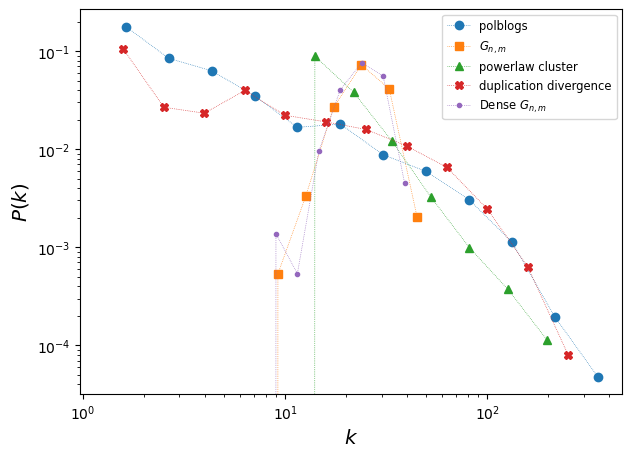

In [30]:
fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)

x0,y0 = degree_distribution(G0, number_of_bins=12)
x1,y1 = degree_distribution(G1, number_of_bins=12)
x2,y2 = degree_distribution(G2, number_of_bins=12)
x3,y3 = degree_distribution(G3, number_of_bins=12)
x4,y4 = degree_distribution(G4, number_of_bins=15)
ax.loglog(x0,y0,marker='o',lw=0.5,ls=':',label='polblogs')
ax.loglog(x1,y1,marker='s',lw=0.5,ls=':',label=r'$G_{n,m}$')
ax.loglog(x2,y2,marker='^',lw=0.5,ls=':',label='powerlaw cluster')
ax.loglog(x3,y3,marker='X',lw=0.5,ls=':',label='duplication divergence')
ax.loglog(x4,y4,marker='.',lw=0.5,ls=':',label='Dense $G_{n,m}$')

ax.legend(fontsize='small')
ax.set_xlabel(r'$k$',fontsize='x-large')
ax.set_ylabel(r'$P(k)$',fontsize='x-large')

plt.show()

________________

## Paths and Components

Let us defines a __path__ $P_{i_0,i_n}$ in a graph $G = (V,E)$ as an *ordered collection* of vertices $\{i_0, i_1, \dots, i_n \}$ and $n$ edges $\{(i_0,i_1), (i_1,i_2), \dots, (i_{n-1},i_n) \}$ such that $i_a \in V$ and $(i_{a-1},i_a) \in E, \forall a$. The path $P_{i_0,i_n}$ connects nodes $i_0$ and $i_n$ and its **length** is $n$.

**Note:** The number of paths of length $n$ between two nodes $i$ and $j$ is equivalent to the element $i,j$ of the $n$th power of the adjacency matrix $A$.

- A **shortest-path** (or *geodesic path*) is the shortest path connecting two vertices.
- The **eccentricity** $\epsilon$ of a vertex $i$ is the longest shortest-path between vertex $i$ and any other vertex $j$.
- The **radius** $r$ of a graph $G=(V,E)$ is the *minimum* eccentricity of any node in $V$.
- The **diameter** $d$ of a graph $G=(V,E)$ is the *maximum* eccentricity of any node in $V$.
- A **cycle** (or loop) is a closed path (i.e. $i_0 = i_n$) in which all vertices and all edges are distinct. If a graph $G=(V,E)$ does not contain any cycle, than such graph is said to be **acyclic**. Instead, if it contains at least one cycle, the graph is said to be **cyclic**.

**We'll be diving into paths more thoroughly in later lessons, but to kick things off today, let's define these terms above**... 

Starting with *shortest path*.

In [3]:
G = nx.karate_club_graph()

Question: What is our "shortest path" function meant to do?

1. **Goal: I want to know the shortest path from node *i* to node *j***.
2. **Goal: I want to know the shortest paths from all nodes *i* to all other nodes *j***.

In [4]:
node_i = 0
# For a given node i, let's initialize all other nodes to be -1 (infinite) hops away
distances = {i: -1 for i in G.nodes()}

# And distance of 0 from node_i to itself
distances[node_i] = 0

# I'll need to make a queue of nodes to search... How to do this?
pass

### Breadth-first search (BFS)
![images/BFS.gif](images/BFS.gif)
________

In [17]:
# Queue of nodes to visit next, starting with our source node_i
queue = [node_i]

# We want to:
### 1. Start with one element in our queue
### 2. Find its neighbors and add them to our queue
### 3. Select one of the neighbors from the queue
### 4. Add its neighbors to our queue
### 5. And so on, until the queue has been depleted

# This is a great time for a `while` loop!

# while there is still a queue of any positive length (instead of len(queue)>0)...
while queue:
    # select oldest item in the list (as opposed to last item)
    current_node = queue.pop(0)

    # find all the 
    for next_node in G.neighbors(current_node):
        if distances[next_node] < 0:
            # set next_node's distance to be +1 whatever the distance to the current node is
            ### e.g. if current_node distance is 0, its neighbors will be 0+1 distance away
            ### ... and so on
            distances[next_node] = distances[current_node] + 1

            # and since we havent seen next_node before (distance still < 0)
            # we will need to append it to our queue
            queue.append(next_node)

Queue = grocery store line, stack = vertical, only can take out the last

In [18]:
pos = nx.spring_layout(G)

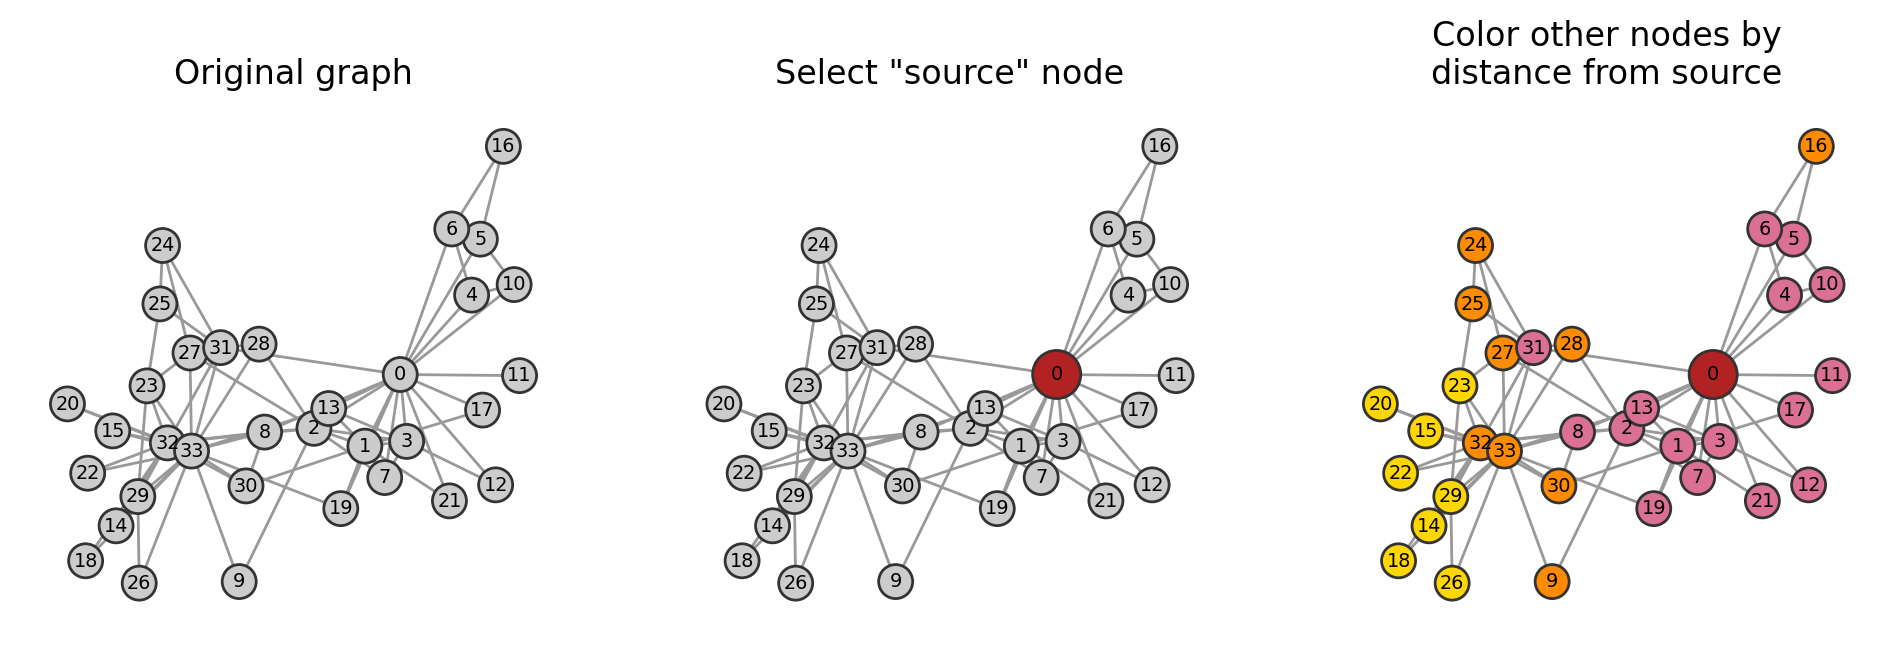

In [19]:
fig, ax = plt.subplots(1,3,figsize=(12,3.5),dpi=200)

dist_col_map = {0:'firebrick',
                1:'palevioletred',
                2:'darkorange',
                3:'gold'}

node_cols0 = ['.8' for i in G.nodes()]
nx.draw(G, pos, node_size=150, node_color=node_cols0, edgecolors='.2',
        with_labels=True, font_size='x-small', edge_color='.6', ax=ax[0])

node_cols1 = ['firebrick' if i==node_i else '.8' for i in G.nodes()]
nx.draw(G, pos, node_size=[300 if i==node_i else 150 for i in G.nodes()],
        node_color=node_cols1, edgecolors='.2',
        with_labels=True, font_size='x-small', edge_color='.6', ax=ax[1])

node_cols2 = [dist_col_map[i] for i in distances.values()]
nx.draw(G, pos, node_size=[300 if i==node_i else 150 for i in G.nodes()],
        node_color=node_cols2, edgecolors='.2',
        with_labels=True, font_size='x-small', edge_color='.6', ax=ax[2])

ax[0].set_title('Original graph')
ax[1].set_title('Select "source" node')
ax[2].set_title('Color other nodes by\ndistance from source')


plt.show()

#### Putting it all together

**Your turn!**

Finish the function `all_shortest_from` below. We'll need it for an exercise shortly.

In [20]:
def all_shortest_from(G, node_i):
    """
    For a given node_i in the network, construct a dictionary containing
    the length of the shortest path between that node and all others in
    the network. Values of -1 correspond to nodes where no paths connect
    to node_i.
    
    Parameters
    ----------
    G (nx.Graph)
        the graph in question
    
    node_i (int or str)
        the label of the "source" node
    
    Returns
    -------
    distances (dict)
        dictionary where the key corresponds to other nodes in the network
        and the values indicate the shortest path length between that node
        and the original node_i source.
    
    """
    
    pass
    
    return distances

____________

In [21]:
def all_shortest_from(G, node_i):
    """
    For a given node_i in the network, construct a dictionary containing
    the length of the shortest path between that node and all others in
    the network. Values of -1 correspond to nodes where no paths connect
    to node_i.
    
    Parameters
    ----------
    G (nx.Graph)
        the graph in question
    
    node_i (int or str)
        the label of the "source" node
    
    Returns
    -------
    distances (dict)
        dictionary where the key corresponds to other nodes in the network
        and the values indicate the shortest path length between that node
        and the original node_i source.
    
    """
    
    distances = {i: -1 for i in G.nodes()}

    # And distance of 0 from node_i to itself
    distances[node_i] = 0

    # Queue of nodes to visit next, starting with our source node_i
    queue = [node_i]

    # We want to:
    ### 1. Start with one element in our queue
    ### 2. Find its neighbors and add them to our queue
    ### 3. Select one of the neighbors from the queue
    ### 4. Add its neighbors to our queue
    ### 5. And so on, until the queue has been depleted

    # This is a great time for a `while` loop!

    # while there is still a queue of any positive length (instead of len(queue)>0)...
    while queue:
        # select oldest item in the list (as opposed to last item)
        current_node = queue.pop(0)

        # find all the 
        for next_node in G.neighbors(current_node):
            if distances[next_node] < 0:
                # set next_node's distance to be +1 whatever the distance to the current node is
                ### e.g. if current_node distance is 0, its neighbors will be 0+1 distance away
                ### ... and so on
                distances[next_node] = distances[current_node] + 1

                # and since we havent seen next_node before (distance still < 0)
                # we will need to append it to our queue
                queue.append(next_node)    
    
    return distances

#### From above:
- A **shortest-path** (or *geodesic path*) is the shortest path connecting two vertices.
- The **eccentricity** $\epsilon$ of a vertex $i$ is the longest shortest-path between vertex $i$ and any other vertex $j$.
- The **radius** $r$ of a graph $G=(V,E)$ is the *minimum* eccentricity of any node in $V$.
- The **diameter** $d$ of a graph $G=(V,E)$ is the *maximum* eccentricity of any node in $V$.
- A **cycle** (or loop) is a closed path (i.e. $i_0 = i_n$) in which all vertices and all edges are distinct. If a graph $G=(V,E)$ does not contain any cycle, than such graph is said to be **acyclic**. Instead, if it contains at least one cycle, the graph is said to be **cyclic**.

**Your turn!**

1. Use your function `all_shortest_paths` above to compute the shortest path lengths for every node in `G`.

2. Use this to calculate the following:
    - A) The **eccentrity** of all nodes in `G`
    - B) The **radius** of `G`
    - C) The **diameter** of `G`
    
3. Cross-reference your answer with the output from `networkx`.

In [22]:
pass

__________

In [23]:
print("Radius:",nx.radius(G))
print("Diameter:",nx.diameter(G))
print(nx.eccentricity(G))

Radius: 3
Diameter: 5
{0: 3, 1: 3, 2: 3, 3: 3, 4: 4, 5: 4, 6: 4, 7: 4, 8: 3, 9: 4, 10: 4, 11: 4, 12: 4, 13: 3, 14: 5, 15: 5, 16: 5, 17: 4, 18: 5, 19: 3, 20: 5, 21: 4, 22: 5, 23: 5, 24: 4, 25: 4, 26: 5, 27: 4, 28: 4, 29: 5, 30: 4, 31: 3, 32: 4, 33: 4}


_______________

### Segue: A special kind of "path"

Remember from above: The number of paths of length $l$ between two nodes $i$ and $j$ in a graph can be found in the $ij^{th}$ element of the $l^{th}$ power of the adjacency matrix $A$.

In [24]:
A = nx.to_numpy_array(G, weight=None)

In [25]:
A

array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [26]:
# recall that matrix multiplication in numpy is done as follows:
A @ A

array([[16.,  7.,  5., ...,  0.,  3.,  4.],
       [ 7.,  9.,  4., ...,  1.,  2.,  3.],
       [ 5.,  4., 10., ...,  3.,  1.,  6.],
       ...,
       [ 0.,  1.,  3., ...,  6.,  1.,  2.],
       [ 3.,  2.,  1., ...,  1., 12., 10.],
       [ 4.,  3.,  6., ...,  2., 10., 17.]])

Take a moment to interpret what this is showing.
- What do the diagonal elements correspond to?
- What do the off-diagonal elements correspond to?
- Is this matrix symmetric?

What if we take the third power, $A^3$, of the adjacency matrix?

In [27]:
A @ A @ A

array([[36., 37., 42., ..., 27., 12., 14.],
       [37., 24., 34., ..., 13., 11., 13.],
       [42., 34., 22., ..., 13., 32., 22.],
       ...,
       [27., 13., 13., ...,  6., 31., 36.],
       [12., 11., 32., ..., 31., 26., 40.],
       [14., 13., 22., ..., 36., 40., 30.]])

How does this operation relate to the `networkx` function `nx.triangles`?

In [28]:
pass

______

## Clustering 

Node degree tells us how many neighbors each vertex has. However, we might also want to know how one node's neighbors are related to each other. We can intuit this by imagining paths of length three in our graph. The concept of ***clustering*** (or *transitivity* in the context of sociology) refers exaclty to this: the tendency for nodes to form cliques around a given vertex.

### Local Clustering

Given an ***undirected*** graph $G=(V,E)$, let us define the ***local clustering coefficient*** as the probability that any two neighbors $j$ and $k$ of node $i$ are connected:

$$ C(i) = 
\begin{cases}
    \frac{e_i}{k_i(k_i-1)/2}       & \quad \text{if } k_{i}>1\\
    0                              & \quad \text{if } k_{i}\leq 1\\
\end{cases},
$$

where $k_i$ is the degree of node $i$ and $e_i$ the number of edges that exists between the neighbors of node $i$. In other words, the clustering coefficient of a node represents the ratio between the number of triangles in the subgraph $G'$ induced by node $i$ and its neighbors over the number of all possible triangles that would be present if $G'$ was a complete graph.

The average clustering coefficient of a network, then, is simply: $\langle C \rangle = \frac{1}{N}\sum_i C(i)$.

In ***directed*** graphs, the definition of clustering can be further refined since 8 different types of triangles can be present in our graph; see [Fagiolo (2007)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.76.026107).

In [29]:
G = nx.karate_club_graph()

In [30]:
# Step 1: Select a random node, i
i = 0

# Step 2: Get all the neighbors of node i
G.neighbors(i)

# Step 3: How do we get all the ***possible*** triangles?

#### Interlude: `itertools` — Functions creating iterators for efficient looping
This module implements a number of iterator building blocks inspired by constructs from APL, Haskell, and SML. Each has been recast in a form suitable for Python.

The module standardizes a core set of fast, memory efficient tools that are useful by themselves or in combination. Together, they form an “iterator algebra” making it possible to construct specialized tools succinctly and efficiently in pure Python.

Source: https://docs.python.org/3/library/itertools.html

In [49]:
from itertools import combinations # Return successive r-length combinations of elements in the iterable.

In [55]:
list1 = [1,2,3,4,5]
r = 1

list(combinations(list1, r))

[(1,), (2,), (3,), (4,), (5,)]

In [56]:
r = 2
list(combinations(list1, r))

[(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5)]

In [64]:
node_i = 0
neighbors_i = list(G.neighbors(node_i))
print("node %i is connected to nodes:"%node_i,neighbors_i)

node 0 is connected to nodes: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]


In [84]:
possible_triangle_edges_i = list(combinations(neighbors_i,2))
print("The potential neighbor-neighbor edges among node %i's neighbors is:"%node_i,
      possible_triangle_edges_i, '\n\n(length = %i)'%len(possible_triangle_edges_i))

The potential neighbor-neighbor edges among node 0's neighbors is: [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 10), (1, 11), (1, 12), (1, 13), (1, 17), (1, 19), (1, 21), (1, 31), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 10), (2, 11), (2, 12), (2, 13), (2, 17), (2, 19), (2, 21), (2, 31), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 10), (3, 11), (3, 12), (3, 13), (3, 17), (3, 19), (3, 21), (3, 31), (4, 5), (4, 6), (4, 7), (4, 8), (4, 10), (4, 11), (4, 12), (4, 13), (4, 17), (4, 19), (4, 21), (4, 31), (5, 6), (5, 7), (5, 8), (5, 10), (5, 11), (5, 12), (5, 13), (5, 17), (5, 19), (5, 21), (5, 31), (6, 7), (6, 8), (6, 10), (6, 11), (6, 12), (6, 13), (6, 17), (6, 19), (6, 21), (6, 31), (7, 8), (7, 10), (7, 11), (7, 12), (7, 13), (7, 17), (7, 19), (7, 21), (7, 31), (8, 10), (8, 11), (8, 12), (8, 13), (8, 17), (8, 19), (8, 21), (8, 31), (10, 11), (10, 12), (10, 13), (10, 17), (10, 19), (10, 21), (10, 31), (11, 12), (11, 13), (11, 17), (11, 19), (11, 21), (11, 31), (1

Recall above: How many possible edges should we expect based on the equation above?

In [75]:
node_i = 0
k_i = G.degree(node_i)
print(k_i)

16


In [87]:
# according to the equation above, we know the denominator should be k_i(k_i-1)/2
possible_triangles_i = k_i * (k_i-1)/2
possible_triangles_i

# what is the numerator? **the number of edges between nodes that are neighbors of node_i**

120.0

In [89]:
actual_triangles_i = sum([1 for neigh_i,neigh_j in possible_triangle_edges_i
                          if neigh_j in G.neighbors(neigh_i)])

In [90]:
clustering_i = actual_triangles_i/possible_triangles_i
clustering_i

0.15

In [92]:
nx.clustering(G)[0]

0.15

In [101]:
clustering_dict = {}
for node_i in G.nodes():
    k_i = G.degree(node_i)
    neighbors_i = list(G.neighbors(node_i))

    possible_triangle_edges_i = list(combinations(neighbors_i,2))
    possible_triangles_i = k_i * (k_i-1) / 2

    actual_triangles_i = sum([1 for neigh_i,neigh_j in possible_triangle_edges_i
                              if neigh_j in G.neighbors(neigh_i)])
    
    if possible_triangles_i > 0:
        clustering_i = actual_triangles_i/possible_triangles_i
    else:
        clustering_i = 0.0
    
    clustering_dict[node_i] = clustering_i

In [105]:
clustering_dict

{0: 0.15,
 1: 0.3333333333333333,
 2: 0.24444444444444444,
 3: 0.6666666666666666,
 4: 0.6666666666666666,
 5: 0.5,
 6: 0.5,
 7: 1.0,
 8: 0.5,
 9: 0.0,
 10: 0.6666666666666666,
 11: 0.0,
 12: 1.0,
 13: 0.6,
 14: 1.0,
 15: 1.0,
 16: 1.0,
 17: 1.0,
 18: 1.0,
 19: 0.3333333333333333,
 20: 1.0,
 21: 1.0,
 22: 1.0,
 23: 0.4,
 24: 0.3333333333333333,
 25: 0.3333333333333333,
 26: 1.0,
 27: 0.16666666666666666,
 28: 0.3333333333333333,
 29: 0.6666666666666666,
 30: 0.5,
 31: 0.2,
 32: 0.19696969696969696,
 33: 0.11029411764705882}

In [106]:
nx.clustering(G)

{0: 0.15,
 1: 0.3333333333333333,
 2: 0.24444444444444444,
 3: 0.6666666666666666,
 4: 0.6666666666666666,
 5: 0.5,
 6: 0.5,
 7: 1.0,
 8: 0.5,
 9: 0,
 10: 0.6666666666666666,
 11: 0,
 12: 1.0,
 13: 0.6,
 14: 1.0,
 15: 1.0,
 16: 1.0,
 17: 1.0,
 18: 1.0,
 19: 0.3333333333333333,
 20: 1.0,
 21: 1.0,
 22: 1.0,
 23: 0.4,
 24: 0.3333333333333333,
 25: 0.3333333333333333,
 26: 1.0,
 27: 0.16666666666666666,
 28: 0.3333333333333333,
 29: 0.6666666666666666,
 30: 0.5,
 31: 0.2,
 32: 0.19696969696969696,
 33: 0.11029411764705882}

In [109]:
np.mean(list(clustering_dict.values()))

0.5706384782076823

In [110]:
nx.average_clustering(G)

0.5706384782076823

In [111]:
# print({i:len(list(combinations(list(G.neighbors(i)),2))) for i in G.nodes()})
# print()
# print({ node:deg*(deg-1)/2 for node, deg in degs.items()})
# print()
# print({i:sum([1 for neighs in combinations(list(G.neighbors(i)),2)
#               if neighs[0] in G.neighbors(i)]) for i in G.nodes()})

In [112]:
# print({i:sum([1 for neigh_i,neigh_j in combinations(list(G.neighbors(i)),2)
#               if neigh_j in G.neighbors(neigh_i)]) for i in G.nodes()})

# print()

# print(nx.triangles(G))

### Global Clustering

The ***global clustering coefficient*** measures the total number of closed triangles in a network relative to the number of existing connected triplets (i.e. the number of not closed triangles):

$$ C_{\Delta} = \frac{3\text{ x Number of Triangles}}{\text{Number of Connected Triplets}}$$

where a **connected triplet** is an ordered set of three vertices.

In [76]:
nx.transitivity(G)

0.2556818181818182

In [119]:
A@A@A

array([[36., 37., 42., ..., 27., 12., 14.],
       [37., 24., 34., ..., 13., 11., 13.],
       [42., 34., 22., ..., 13., 32., 22.],
       ...,
       [27., 13., 13., ...,  6., 31., 36.],
       [12., 11., 32., ..., 31., 26., 40.],
       [14., 13., 22., ..., 36., 40., 30.]])

In [114]:
np.trace(A@A@A)/6

45.0

_________
#### Your turn!

Graphs sampled from $G(N,p)$ do not have clustering. Why is that?


The average clustering coefficient in $G(N,p)$ is $ \langle C \rangle = p = \frac{\langle k \rangle}{N}. $ Show this numerically.

In [146]:
N = 500
ps = np.logspace(-3,-0.5,20)
niter = 100
clustering = []

for p in ps:
    tmp = []
    for _ in range(niter):
        G_i = nx.erdos_renyi_graph(N,p)
        tmp.append(nx.transitivity(G_i))
    
    clustering.append(np.mean(tmp))

0.001
0.00135
0.00183
0.00248
0.00336
0.00455
0.00616
0.00834
0.01129
0.01528
0.02069
0.02801
0.03793
0.05135
0.06952
0.09412
0.12743
0.17252
0.23357
0.31623


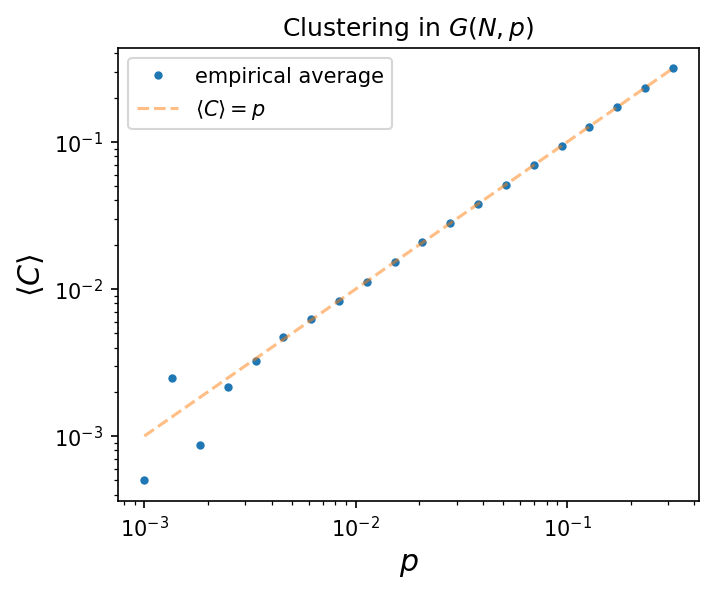

In [161]:
fig, ax = plt.subplots(1,1,figsize=(5,4),dpi=150)

ax.loglog(ps, clustering, marker='.', lw=0, label='empirical average')
ax.loglog(ps, ps, label=r'$\langle C \rangle = p$', alpha=0.5, ls='--')

ax.legend()
ax.set_xlabel(r'$p$', fontsize='x-large')
ax.set_ylabel(r'$\langle C \rangle$', fontsize='x-large')

ax.set_title(r'Clustering in $G(N,p)$')

plt.show()

____________

#### Want more? In your own time...

1. The **weighted clustering** of node $i$ in an undirected weighted graph $G$ can be defined as:

$$ C^w(i) = \frac{1}{s_i(k_i-1)} \sum_{j=1}^N\sum_{h=1}^N \frac{w_{i,j} + w_{i,h}}{2}A_{i,j}A_{i,h}A_{j,h} $$

where $s_i$ is the *stength* of node $i$, $k_i$ is the degree of node $i$, and $w_{i,j}$ is the weight associated to the edge connecting nodes $i$ and $j$.

Write a function that computes the weighted clusterings $C^w(i)$ for all nodes in an undirected weighted graph.

2. Use a *depth-first search* (DFS) to find connected components in a graph.

Below is an example of the order that nodes are searched in DFS.

![https://upload.wikimedia.org/wikipedia/commons/1/1f/Depth-first-tree.svg](https://upload.wikimedia.org/wikipedia/commons/1/1f/Depth-first-tree.svg)

And a helpful gif:
![images/BFS.gif](images/DFS.gif)

In [48]:
pass

<!-- ### Graph Components

A graph is said to be __connected__ if there exists a path connecting any two vertices in the graph.

An undirected and connected graph without closed loops is also a __tree__. 

A __component__ $C$ of a graph $G=(V,E)$ is defined as a connected subgraph of $G$. The __giant component__ of a graph is defined as the component whose size scales with the number of vertices of the graph (i.e. it diverges in the limit $N\rightarrow\infty$).

In a _directed graph_, a ___weakly connected component___ is the connected subgraph where we consider all paths disregarding the direction of the edges and considering the graph _as if_ it were undirected. Instead, a ___strongly connected component___ is the connected subgraph when we do consider the directionality of the links. 

Also the definition of the giant component changes in the directed graphs. Let us define the __giant weakly connected component__ (GWCC) as the giant component of the directed graph if we do not consider the directed nature of the edges. Then, we can decompose the GWCC into:
* a __giant strongly connected component__ (GSCC) in which there exists a directed edge joining any pair of nodes in the GWCC;
* a __giant in-component__ (GIN) formed by the nodes from which it is possible to reach the GSCC by means of a directed path;
* a __giant out-component__ (GOUT) formed by the nodes that it is possible to reach from the GSCC by means of a directed path;
* __tendrils__ formed by nodes for which it does not exist a directed path that allows them to reach the GSCC, or to be reached from the GSCC;
* __tubes__ formed by nodes that belong to a directed path connecting GIN to GOUT without crossing the GSCC.

<img src="./img/bowtie.png" alt="bowtie" width="300">



The first question we generally ask about navigation is: can we construct a path between any pair of nodes in the network? There are actually two questions combined into one here: is it possible *in principle* to build such a path?, and can we actually *find* such a path if we know one exists?

The first question deals with the *connectedness* of a network. A network is *connected* if there exists a path between every pair of nodes, and *disconnected* otherwise. A disconnected network is really just the same as two networks side by side, of course, but it sometimes makes sense to consider these two "independent" networks to be part of "the same" network. A good example is the street plan of Greater New York, which we might consider to be one big network but which is composed of several sub-networks disconnected by New York harbour into the street plan of Manhatten, the street plan of Staten Island, and so forth.

We refer to the parts of a network that are connected as the *components* of the network, and it is by definition possible to find a path between any pair of nodes within the same component. (And, also by definition, impossible to find a path between two nodes in different components.)

This brings us to the second question above &ndash; finding paths even when we know they exist &ndash; and this is, perhaps surprisingly, not a question that's always easily answered. In the mesh we've been considering, it's easy to see how to construct a path between any pair of nodes: go "across" the rows until the appropriate column, and then "up" (or "down") to the appropriate row. This is sometimes called *Manhatten routing*, and is an algorithm that will be familiar to anyone who's ever visited a major American city. It is probably most notable for *not* working in non-mesh-like cities such as are found in much of Europe (and in smaller, older, American towns &ndash; or indeed in the older parts of New York), where the network of streets is more complex.

In a network with a more complex structure, it will clearly be considerably harder to find a path. Put another way, an algorithm like Manhatten routing lets us define the path between two nodes, but there may not *be* an algorithm for other classes of network. Fortunately we often don't need to be able to find specific paths: it's enough to know that they exist (or don't) in principle &ndash; or even, sometimes, that they *probably* exist (or don't).



___

Let's return to [paths](#concepts_paths_paths) in a more global sense. For any pair of nodes there will often be multiple paths between them, some longer and some shorter. The *shortest path* between two nodes is clearly of some significance: it's the "quickest route" between two points in the network. There may be several paths with the same length, in which case they would all be "shortest", but typically there is one that's shorter than the rest. By definition this path will not be self-intersecting, and will be the network equivalent of a "straight line" between the two nodes concerned. -->

__________
## Next time...
Degree, path lengths, triangles: these are all different ways to understand an individual node's role/status/importance in networks. Next time, we'll start to ask about distributions of network properties & explore even more centralities! `class_04_distributions.ipynb`
_______

# References and further resources:

1. Class Webpages
    - Jupyter Book: https://asmithh.github.io/network-science-data-book/intro.html
    - Github: https://github.com/asmithh/network-science-data-book
    - Syllabus and course details: https://brennanklein.com/phys7332-fall24
2. Fagiolo, G. (2007). Clustering in complex directed networks. *Physical Review E*, 76(2), 026107.
3. Network Science textbook (https://networksciencebook.com/).

__________